In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data = pd.read_csv("spam.csv", encoding = 'latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)
data = data.rename(columns={'v1':'label','v2':'Text'})
data['label_enc'] = data['label'].map({'ham':0, 'spam':1})
data.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


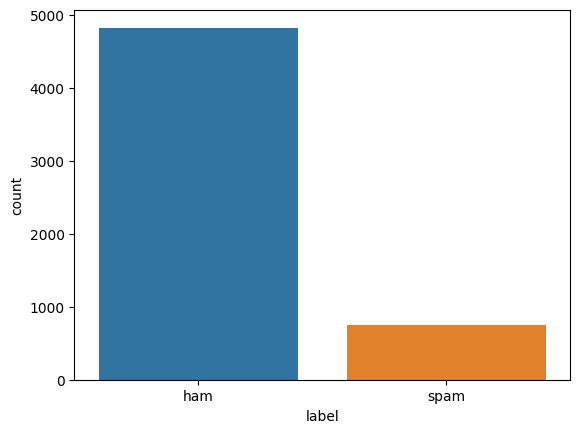

In [ ]:
sns.countplot(x = data['label'])
plt.show()


In [ ]:
avg_words_len = round(sum([len(i.split()) for i in data['Text']])/len(data['Text']))
print(avg_words_len)

15


In [ ]:
s = set()
for sent in data['Text']:
  for word in sent.split():
    s.add(word)
total_words_length = len(s)
print(total_words_length)

15585


In [ ]:
from sklearn.model_selection import train_test_split

X,y = np.asanyarray(data['Text']), np.asanyarray(data['label_enc'])
new_data = pd.DataFrame({'Text': X, 'label': y})
X_train,X_test,y_train,y_test  = train_test_split(new_data['Text'], new_data['label'], test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec, y_train)

MultinomialNB()

In [ ]:
nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(nb_accuracy)

print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



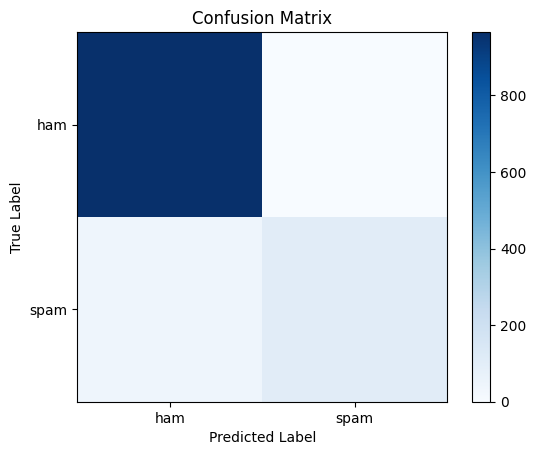

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = baseline_model.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model 1: Custom Layers

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS = total_words_length
OUTPUTLEN = avg_words_len

text_vec = TextVectorization(
    max_tokens = MAXTOKENS,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = OUTPUTLEN
)
text_vec.adapt(X_train)

In [ ]:
sample_sentence = "This is a message"
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
embedding_layer = layers.Embedding(
    input_dim = MAXTOKENS,
    output_dim = 128,
    embeddings_initializer = 'uniform',
    input_length = OUTPUTLEN
)

In [ ]:
input_layer = layers.Input(shape = (1,), dtype = tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)
output_layer = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(
    label_smoothing = 0.5), metrics = ['accuracy'])


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128

In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs = 5, validation_data = (X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 8s 40ms/step - loss: 0.6022 - accuracy: 0.9172 - val_loss: 0.5765 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 4s 29ms/step - loss: 0.5701 - accuracy: 0.9879 - val_loss: 0.5731 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 4s 27ms/step - loss: 0.5657 - accuracy: 0.9960 - val_loss: 0.5724 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5641 - accuracy: 0.9980 - val_loss: 0.5727 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 30ms/step - loss: 0.5635 - accuracy: 0.9993 - val_loss: 0.5724 - val_accuracy: 0.9812


<Axes: >

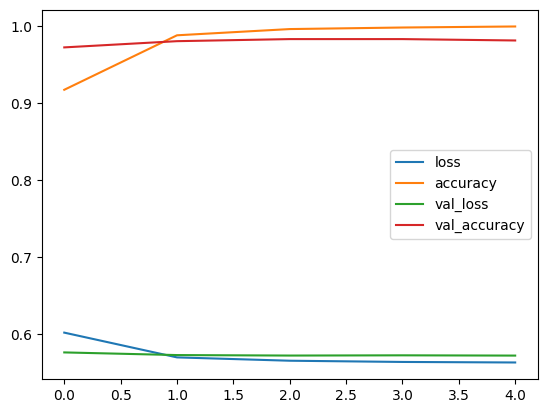

In [ ]:
pd.DataFrame(history_1.history).plot()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
  model.compile(optimizer = keras.optimizers.Adam(),
                loss = keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy'])

def fit_model(model, epochs, X_train = X_train, y_train = y_train,
              X_test = X_test, y_test = y_test):
  history = model.fit(X_train,y_train,
                      epochs = epochs,
                      validation_data = (X_test,y_test),
                      validation_steps = int(0.2*len(X_test)))
  return history

def evaluate_model(model, X, y):
  y_preds = np.round(model.predict(X))
  accuracy = accuracy_score(y,y_preds)
  precision = precision_score(y,y_preds)
  recall = recall_score(y,y_preds)
  f1 = f1_score(y,y_preds)

  model_results_dict = {'accuracy':accuracy,
                        'precision':precision,
                        'recall':recall,
                        'f1-score':f1}
  return model_results_dict

Model 2: Bidirectional LSTM

In [ ]:
input_layer = layers.Input(shape = (1,), dtype = tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation = 'tanh', return_sequences = True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation = 'relu')(dropout)
output_layer = layers.Dense(1,activation = 'sigmoid')(x)
model_2 = keras.Model(input_layer,output_layer)

compile_model(model_2)
history_2 = fit_model(model_2, epochs=5)

Epoch 1/5
140/140 [==============================] - 27s 133ms/step - loss: 0.0611 - accuracy: 0.9821 - val_loss: 0.1047 - val_accuracy: 0.9821
Epoch 2/5
140/140 [==============================] - 13s 96ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1178 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 13s 94ms/step - loss: 2.3686e-04 - accuracy: 0.9998 - val_loss: 0.1141 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 14s 99ms/step - loss: 3.8276e-05 - accuracy: 1.0000 - val_loss: 0.1261 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 14s 102ms/step - loss: 1.6191e-05 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 0.9839


Model 3 : Transfer Learning

In [ ]:
import tensorflow_hub as hub

model_3 = keras.Sequential()
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable = False,
                           input_shape = [],
                           dtype = tf.string,
                           name = 'USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation = keras.activations.relu))
model_3.add(layers.Dense(1, activation = keras.activations.sigmoid))

compile_model(model_3)
history_3 = fit_model(model_3, epochs = 5)


Epoch 1/5
140/140 [==============================] - 8s 23ms/step - loss: 0.3182 - accuracy: 0.9224 - val_loss: 0.1217 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 3s 19ms/step - loss: 0.0837 - accuracy: 0.9791 - val_loss: 0.0723 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0589 - accuracy: 0.9823 - val_loss: 0.0606 - val_accuracy: 0.9794
Epoch 4/5
140/140 [==============================] - 5s 34ms/step - loss: 0.0471 - accuracy: 0.9868 - val_loss: 0.0542 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0385 - accuracy: 0.9886 - val_loss: 0.0515 - val_accuracy: 0.9821


Analyzing Models Performance

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)

model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB':baseline_model_results,
                             'Custom-Vec-Embedding-Model':model_1_results,
                             'Bidirectional-LSTM-Model':model_2_results,
                             'USE-Transfer-Learning-Model':model_3_results}).transpose()
total_results

35/35 [==============================] - 1s 11ms/step


,accuracy,precision,recall,f1-score
MultinomialNB,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding-Model,0.981166,0.977778,0.880000,0.926316
Bidirectional-LSTM-Model,0.983857,0.978261,0.900000,0.937500
USE-Transfer-Learning-Model,0.982063,0.951389,0.913333,0.931973


<Axes: >

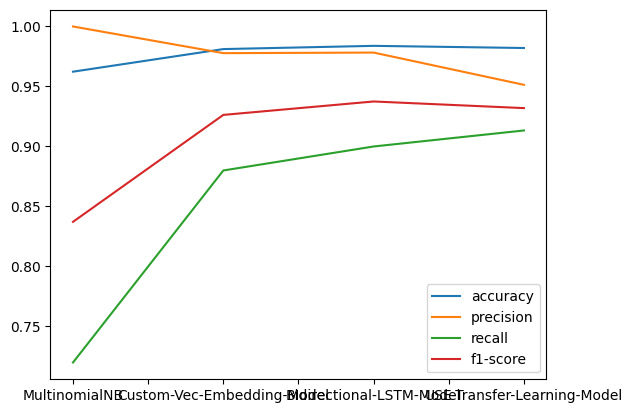

In [ ]:
total_results.plot()